In [1]:
import csv
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
'''홈페이지에 올려주신 내용을 사용한 부분 step, linear, fourier 세가지 종류의 포텐셜을 만들어낸다.'''
def subexp(expon):
    return np.power(abs(np.log(np.random.uniform())),expon)

def generatepot(style,param): #0=step,1=linear,2=fourier; 0-1 "jaggedness" scale
    mu = 1. + bins*param #mean number of jump points for styles 0 + 1
    forxp = 2.5 - 2*param #fourier exponent for style 2
    scale = 5.0*(np.pi*np.pi*0.5) # energy scale
    
    if style < 2:
        dx = bins/mu
        xlist = [-dx/2]
        while xlist[-1] < bins:
            xlist.append(xlist[-1]+dx*subexp(1.))
        vlist = [scale*subexp(2.) for k in range(len(xlist))]
        k = 0
        poten = []
        for l in range(1,bins):
            while xlist[k+1] < l:
                k = k + 1
            if style == 0:
                poten.append(vlist[k])
            else:
                poten.append(vlist[k]+(vlist[k+1]-vlist[k])*(l-xlist[k])/(xlist[k+1]-xlist[k]))
    else:
        sincoef = [(2*np.random.randint(2)-1.)*scale*subexp(2.)/np.power(k,forxp) for k in range(1,bins//2)]
        coscoef = [(2*np.random.randint(2)-1.)*scale*subexp(2.)/np.power(k,forxp) for k in range(1,bins//2)]
        zercoef = scale*subexp(2.)
        poten = np.absolute(np.add(np.add(np.matmul(sincoef,sinval),np.matmul(coscoef,cosval)),zercoef)).tolist()
    poten = 10*scale*(np.asarray(poten)-np.min(np.asarray(poten), axis=-1, keepdims=True))/np.max(np.asarray(poten), axis=-1, keepdims=True)
    return poten

In [3]:
totaliteration = 10000
printiteration = totaliteration//20
bins = 200 #dx = 1/bins; actual number of columns saved = bins-1, because 1st and last are 0
npots = 700 #ends up being 3*this*(validnth-1)/validnth
total_size = bins-1

listvofx = []

sinval = np.sin([[np.pi*i*j/bins for i in range(1,bins)] for j in range(1,bins//2)])
cosval = np.cos([[np.pi*i*j/bins for i in range(1,bins)] for j in range(1,bins//2)])
sqrt2 = np.sqrt(2)

In [4]:
'''만들어낸 포텐셜의 묶음을 seed라고 하고 이중 4번째를 쓴다는 의미
초기에 프사이를 사인꼴로 두고 히든레이어 없이 옵티마이져로 에너지 미니마이즈
이렇게 만든 결과는 정확하지는 않지만 빠르게 구할 수 있다.'''
seed = 4
np.random.seed(seed)
for i in range(npots):
    for j in range(3):
        listvofx.append(generatepot(j,(1.*i)/npots))
npvofx = np.array(listvofx)
np.random.shuffle(npvofx)
listvofx = npvofx.tolist()
tfph_vofx = tf.placeholder(tf.float32, [None, None])
defgrdstate = tf.constant([[sqrt2*np.sin(i*np.pi/bins) for i in range(1,bins)] for j in range (0, npots*3)])
psi = tf.Variable(defgrdstate)
zerotens = tf.zeros([tf.shape(psi)[0], 1])
psil = tf.concat([psi[:, 1:],zerotens],1)
psir = tf.concat([zerotens,psi[:, :-1]],1)
energy = tf.reduce_mean(tf.reduce_mean(tf.subtract(tf.multiply(tf.square(psi),tf.add(tfph_vofx,1.*bins*bins)),tf.multiply(tf.multiply(tf.add(psil,psir),psi),0.5*bins*bins)), axis=-1))
renorm = tf.assign(psi,tf.divide(psi,tf.sqrt(tf.reduce_mean(tf.square(psi), axis=-1, keepdims=True))))
optimzi = tf.train.AdagradOptimizer(learning_rate=0.1)
training = optimzi.minimize(energy)

init = tf.global_variables_initializer()

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
sess.run(init)
_ = sess.run(renorm)

In [6]:
'''진행시간이 오래걸리기 때문에 이를 표시함.'''
prevtime = datetime.now()
for t in range(totaliteration): 
    if t%printiteration==0:
        nowtime = datetime.now()        
        energy_v = sess.run(energy, feed_dict={tfph_vofx:listvofx})        
        print(str((100.*t)/totaliteration) + '% complete')
        print('TakenTime: %s' % (str(nowtime-prevtime)))        
        print('Energy: %s' % (str(energy_v)))
        prevtime = datetime.now() 
    sess.run(training, feed_dict={tfph_vofx:listvofx})    
    sess.run(renorm)
print('Output complete')

0.0% complete
TakenTime: 0:00:00
Energy: 56.79798
5.0% complete
TakenTime: 0:00:12.869545
Energy: 54.7194
10.0% complete
TakenTime: 0:00:11.359617
Energy: 53.216415
15.0% complete
TakenTime: 0:00:13.073035
Energy: 51.970875
20.0% complete
TakenTime: 0:00:11.943059
Energy: 50.904613
25.0% complete
TakenTime: 0:00:11.764535
Energy: 49.977303
30.0% complete
TakenTime: 0:00:11.617927
Energy: 49.16318
35.0% complete
TakenTime: 0:00:11.634881
Energy: 48.443768
40.0% complete
TakenTime: 0:00:11.620917
Energy: 47.804985
45.0% complete
TakenTime: 0:00:11.691731
Energy: 47.235527
50.0% complete
TakenTime: 0:00:11.633885
Energy: 46.726257
55.0% complete
TakenTime: 0:00:13.404150
Energy: 46.26954
60.0% complete
TakenTime: 0:00:13.761193
Energy: 45.858982
65.0% complete
TakenTime: 0:00:13.556742
Energy: 45.489082
70.0% complete
TakenTime: 0:00:13.486928
Energy: 45.15524
75.0% complete
TakenTime: 0:00:13.399163
Energy: 44.85329
80.0% complete
TakenTime: 0:00:13.430081
Energy: 44.579777
85.0% complet

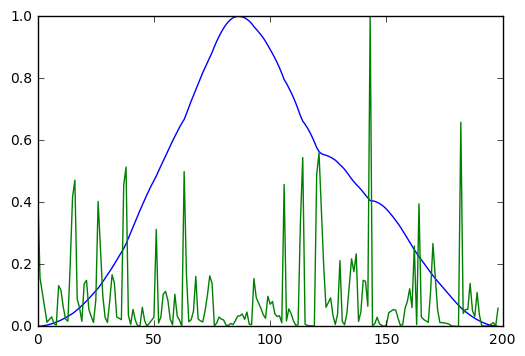

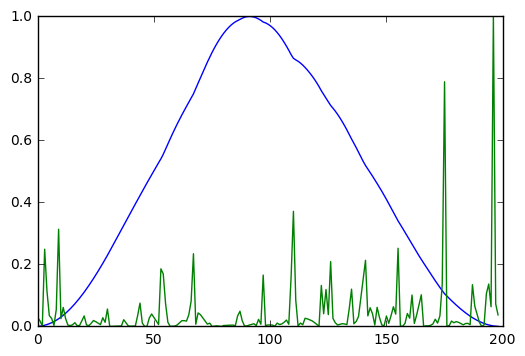

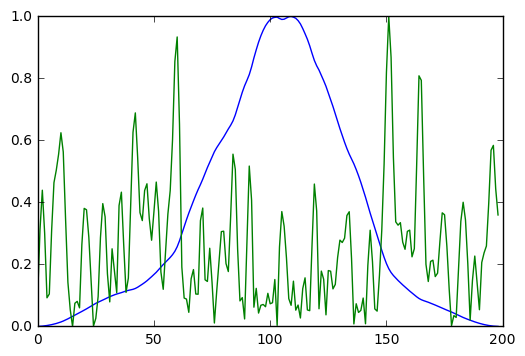

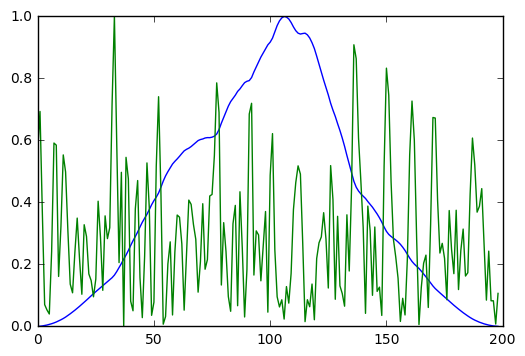

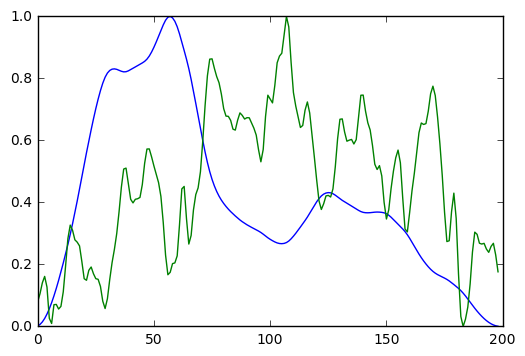

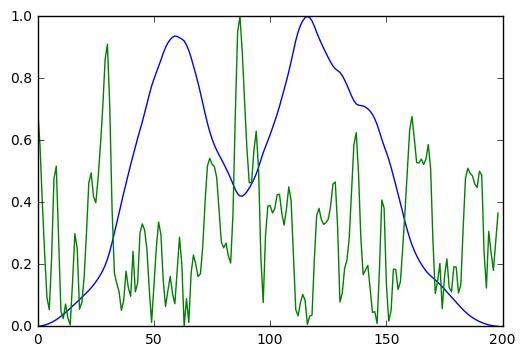

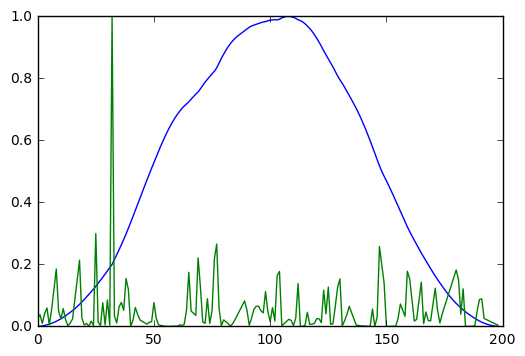

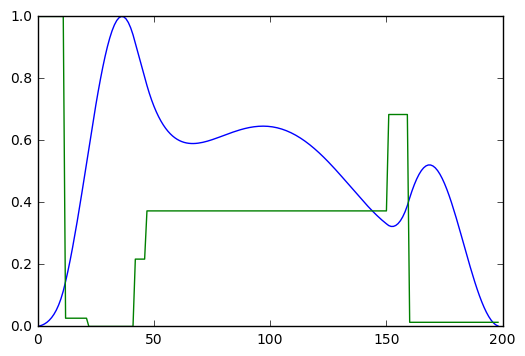

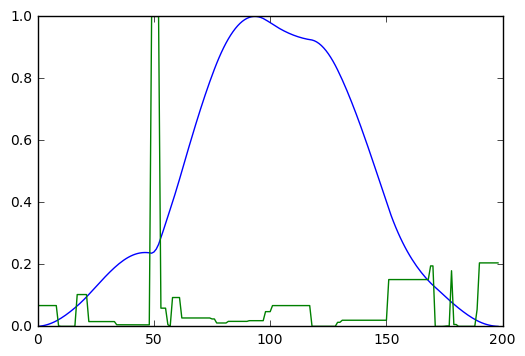

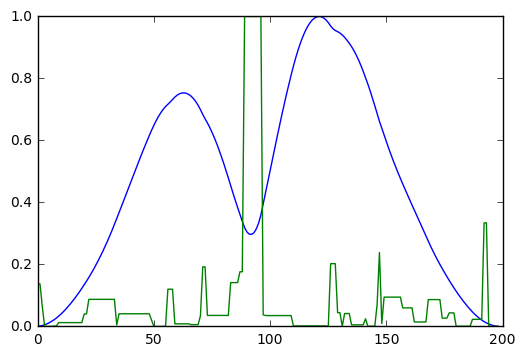

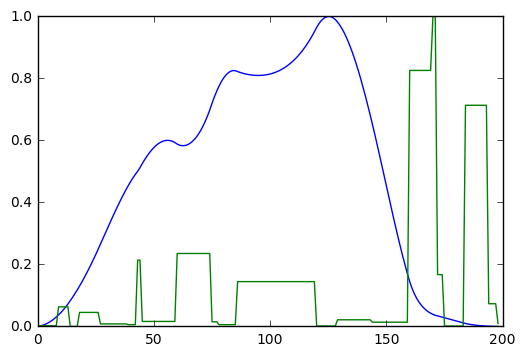

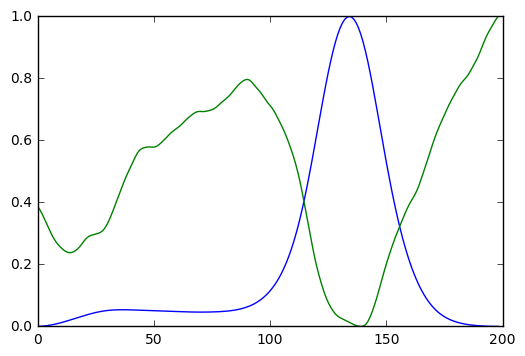

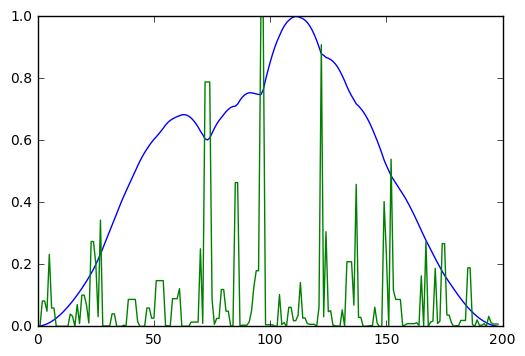

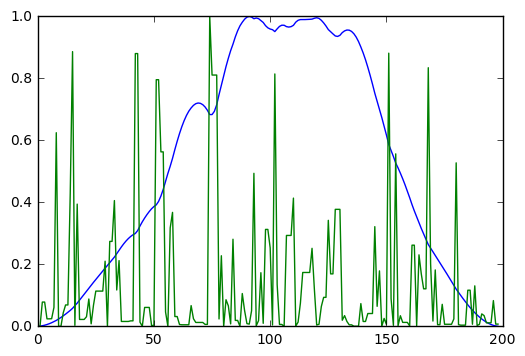

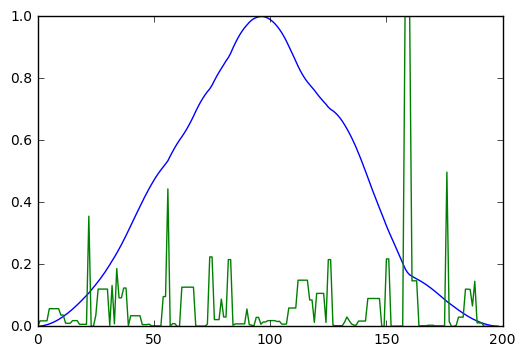

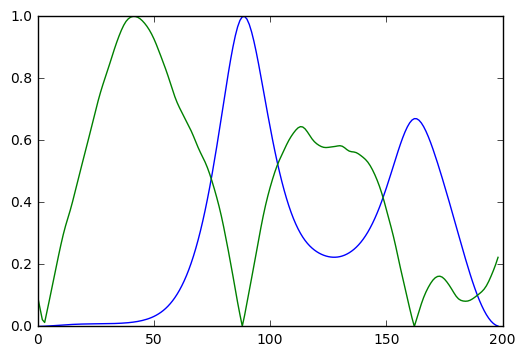

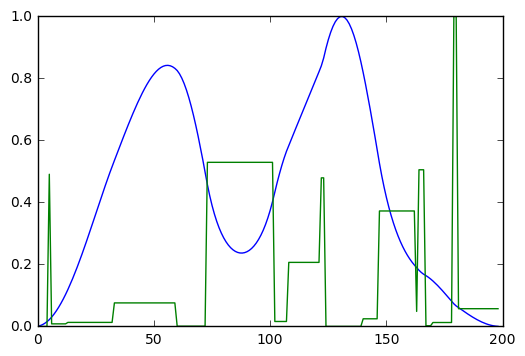

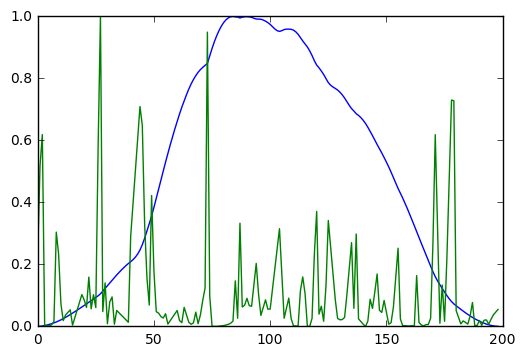

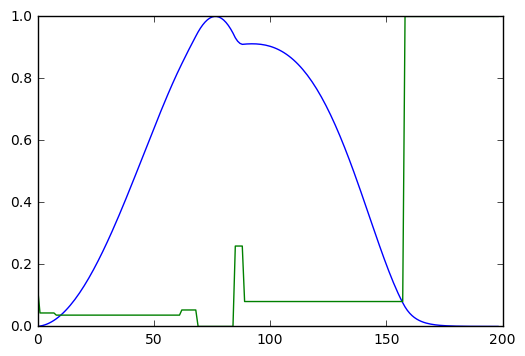

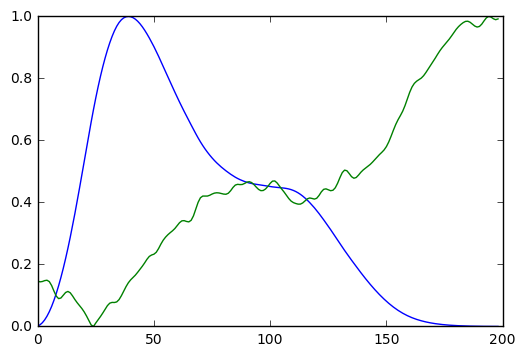

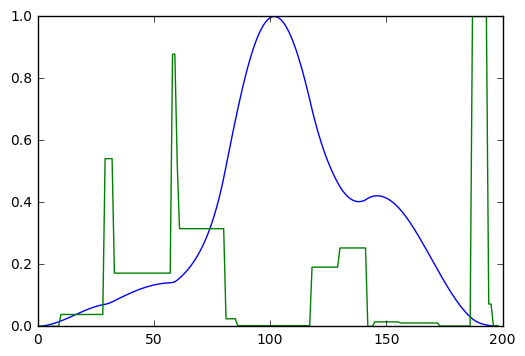

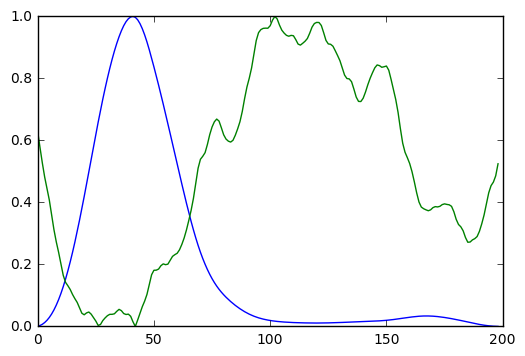

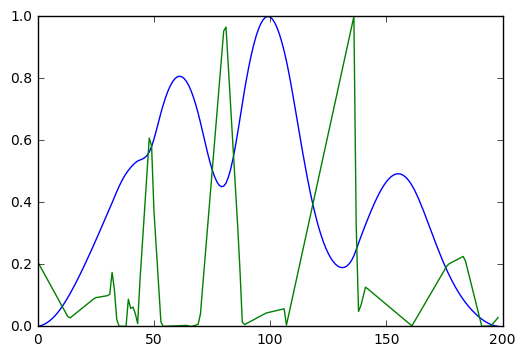

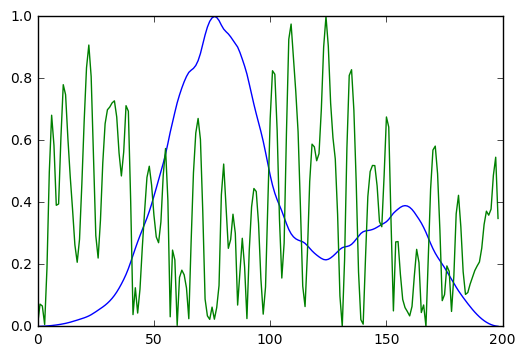

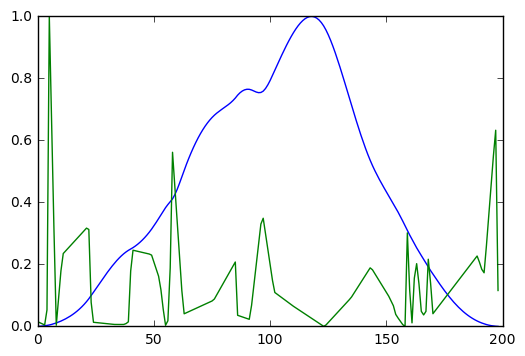

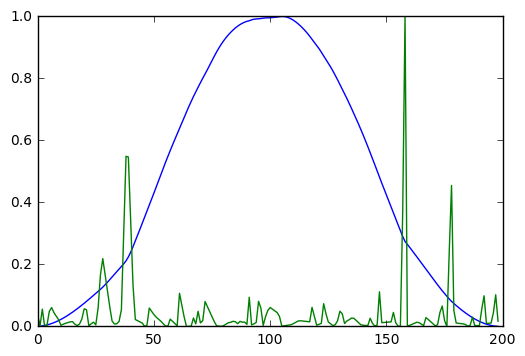

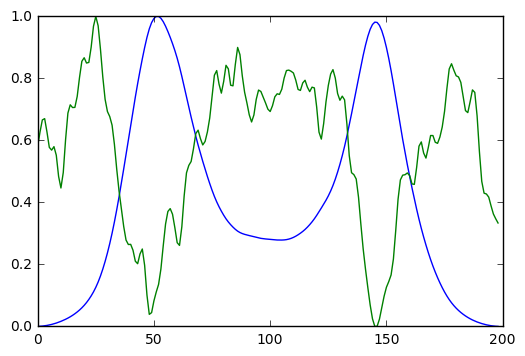

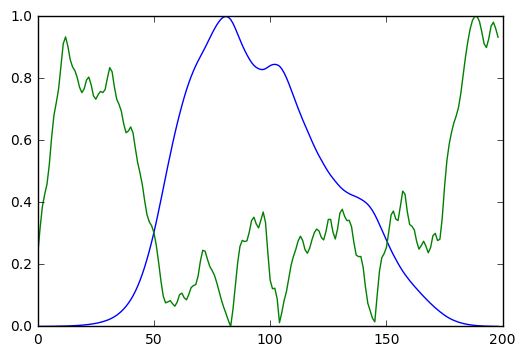

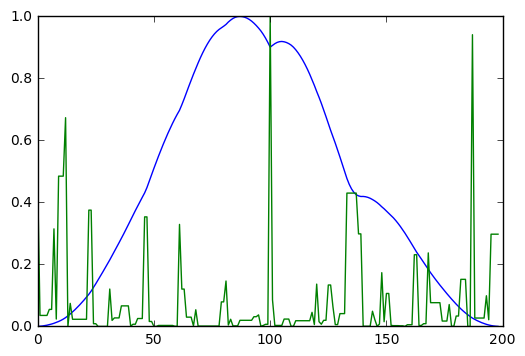

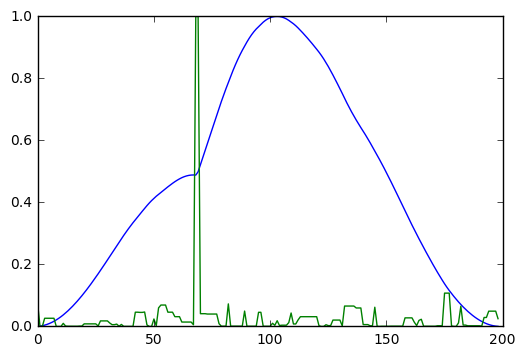

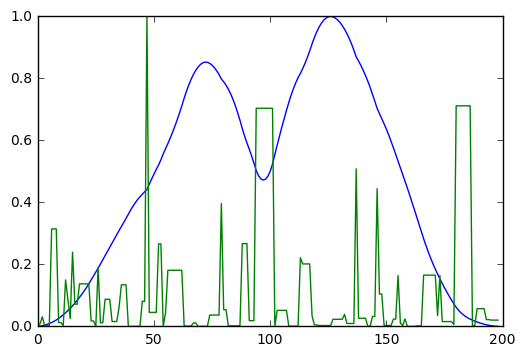

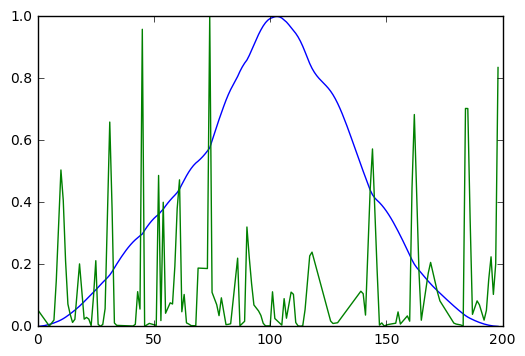

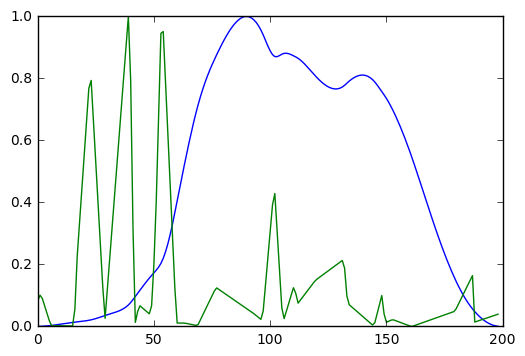

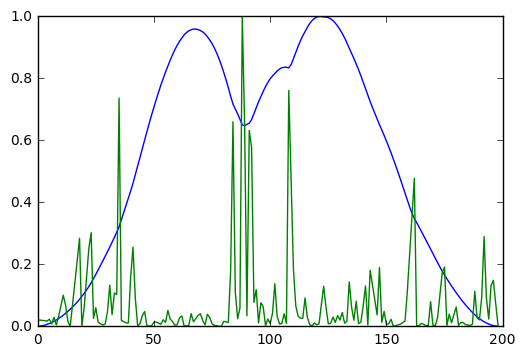

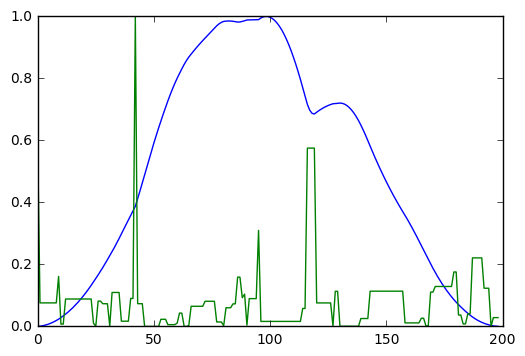

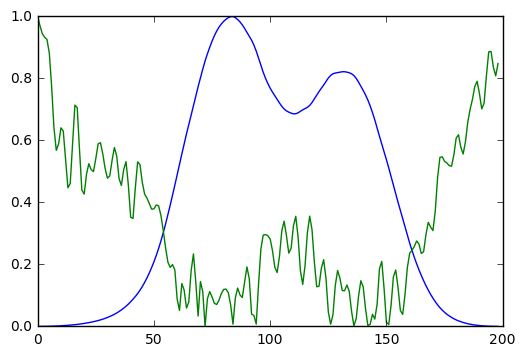

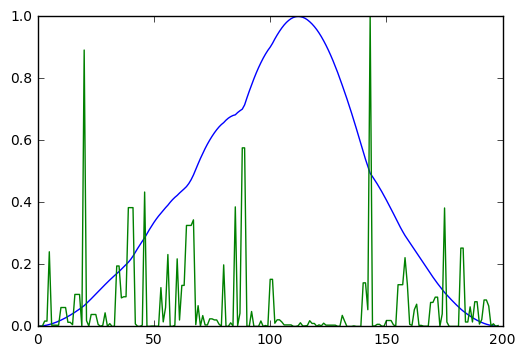

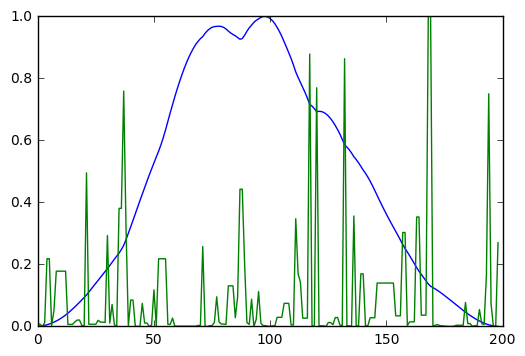

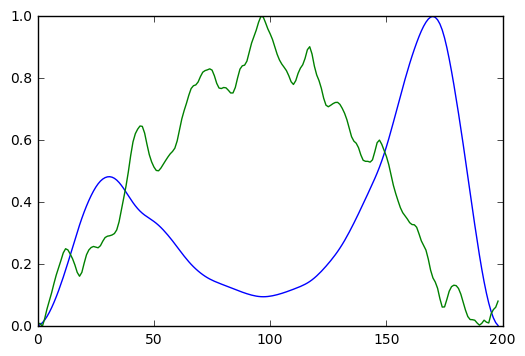

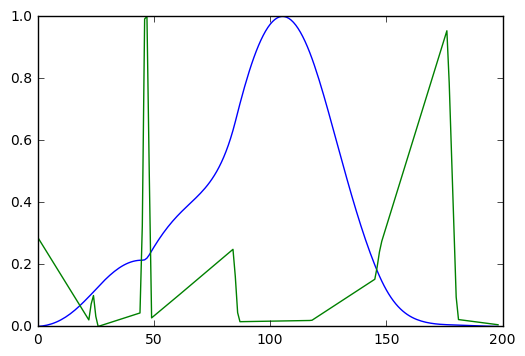

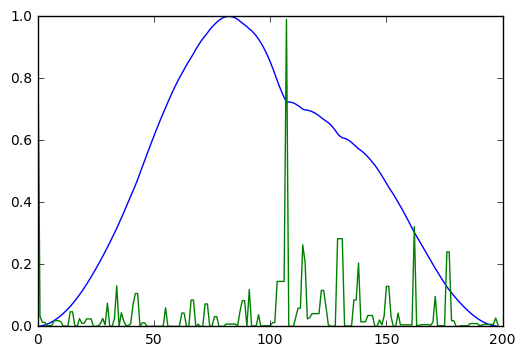

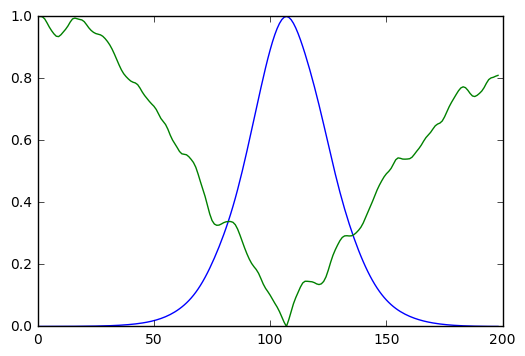

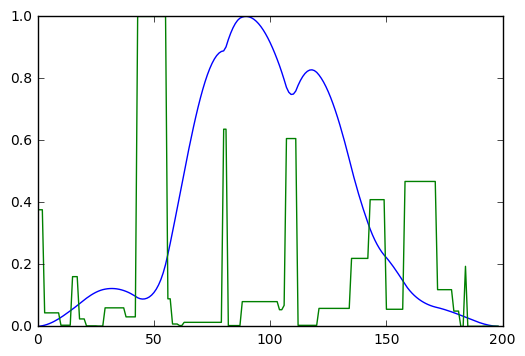

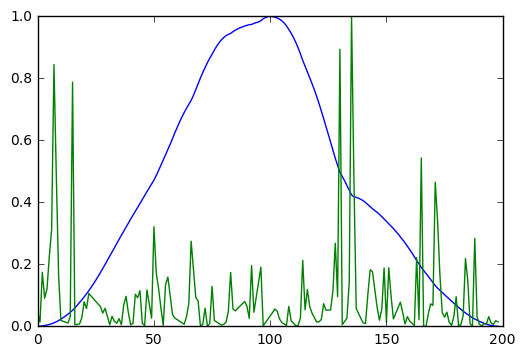

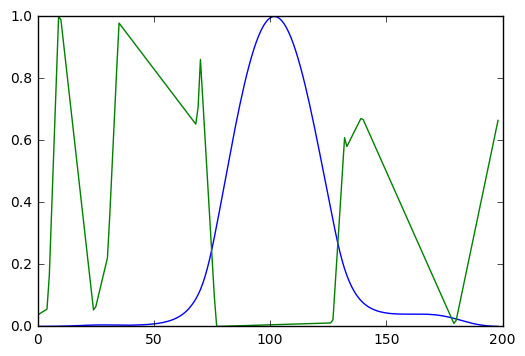

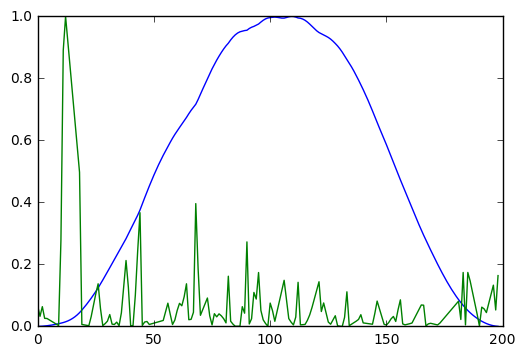

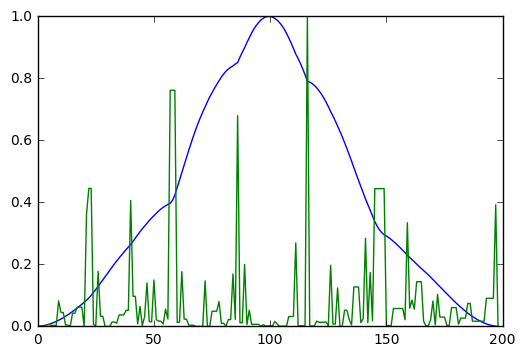

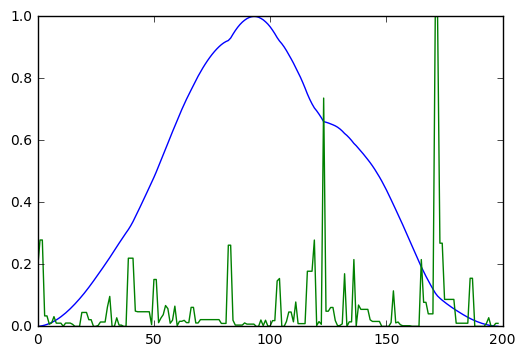

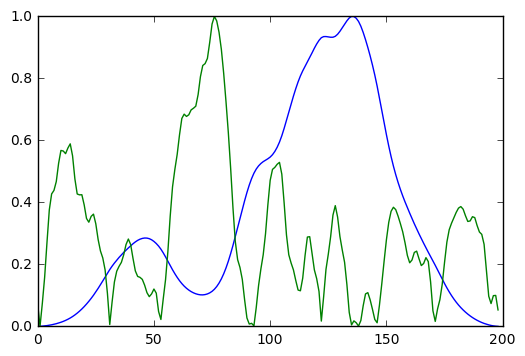

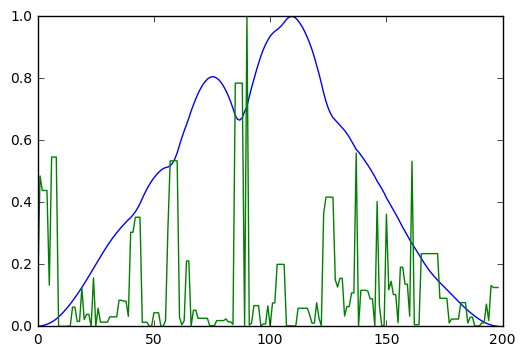

In [7]:
'''프사이함수보다 프사이 제곱이 그 경향성을 더 잘 보여주고 확률분포의 의미가 있으므로 프사이 제곱을 그림.'''
psi_v = sess.run(psi**2, feed_dict={tfph_vofx:listvofx})
for i in range (50):
    plt.plot(psi_v[i]/max(psi_v[i]))
    plt.plot(np.array(listvofx[i])/max(listvofx[i]))
    plt.show()

In [8]:
'''만들어진 포텐셜의 형태
여기에선 199칸으로 2100개의 셈플을 만들었다'''
tfph_vofx_v = sess.run(tfph_vofx, feed_dict={tfph_vofx:listvofx})
print(psi_v.shape)
#3*npots,bins-1
print(tfph_vofx_v.shape)

(2100, 199)
(2100, 199)


In [9]:
###판다스를 이용한 데이터 세이브
'''포테셜 제네레이터 부분과 딥러닝 부분을 분리해서 만들었다.
만든 포텐셜을 csv파일 형식으로 저장하고 딥러닝 부분에서 다시 이를 로드한다.'''
def datacsvSave(dataset, labelset, labelParameterName, datasavepath, labelsavepath):
    df_dataset = pd.DataFrame(np.transpose(dataset))
    df_labelset = pd.DataFrame(np.transpose(labelset), index = labelParameterName)
    df_dataset.to_csv(datasavepath+".csv")
    df_labelset.to_csv(labelsavepath+".csv")
    
save_dir = os.path.join(os.getcwd(), "potential_generator")
if not os.path.exists(save_dir)==True:
    os.makedirs(save_dir)
datasavepath = os.path.join(save_dir, "Dataset")
labelsavepath = os.path.join(save_dir, "Label")
datacsvSave(psi_v, listvofx, None, datasavepath, labelsavepath)